# Exploring how to account for the network separation of nodes on separate connected components

Here, we demonstrate how different penalty term influence the network separation of different groups of randomly chosen proteins.

In [1]:
import random
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import generateCompleteProteome
from pybiomart import Dataset
import ngramNets
from tqdm import tqdm

In [2]:
# Creating some default parameters for future plots.
plt.rcParams['font.size'] = 6
plt.rcParams['axes.labelsize'] = 6
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.01
plt.rcParams['lines.markeredgewidth'] = 0.01

In [3]:
# Setting up a gene ID conversion dataframe
dataset = Dataset(host = 'http://useast.ensembl.org', name='hsapiens_gene_ensembl',)
gene_ID_conv = dataset.query(attributes=['external_gene_name','external_synonym','uniprotswissprot'])
gene_ID_conv.dropna(axis=0, inplace=True)

In [ ]:
# Setting up a complete n-gram network containing all n-grams up to size 10
complete_ref, _ = generateCompleteProteome.import_proteome_files()
complete_network =ngramNets.dansy(ref=complete_ref, n=10)

Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.


In [5]:
# Generating multiple lists of different sizes of randomly chosen genes

group_szs = [5,10,20,30,50,100,125,180,300,1000]

# Setting the random seed state
random.seed(882)
random_nets = {}

for sz in group_szs:
    num_rand_nets = 150
    rand_ids = complete_network.retrieve_random_ids(num=sz, iters=num_rand_nets)
    sz_rand_nets = []
    
    for i in tqdm(range(0, num_rand_nets)):
        rand_net = ngramNets.DomainNgramNetwork(next(rand_ids), ref=complete_ref, n=10, verbose=False)
        sz_rand_nets.append(rand_net)
    random_nets[sz] = sz_rand_nets

100%|██████████| 150/150 [02:46<00:00,  1.11s/it]


In [6]:
# For the network separation there are two values that are needed which include the .

# To compute grabbing a few preliminary values that speed up the calculation that include the shortest path length of the original network, the diameter of the connected components, the isolates, and designating a penalty term (default in the function is dynamic).
reference_data = ngramNets.build_network_reference_dict(complete_network)

In [7]:
# For finding the mean minimum distance, there is no penalty if a node represents an entire connected component.

# For the mean minimum distance we do not want a penalty as we are not trying to connect n-grams representing whole connected components to others in the network. Rather, we are saying they have a distance of 0.
reference_data['penalty'] = 0
rand_net_info = {}
for sz in group_szs:
    mmd = []
    tmp = random_nets[sz]
    total = len(tmp)
    print(f"Starting calculation for networks of size: {sz}")
    for net in tmp:    
        d = ngramNets.mean_minimum_dist(net.G, reference_data)
        mmd.append(d)
    
    rand_net_info[sz] = mmd


tmp_df = pd.DataFrame.from_dict(rand_net_info,orient='index').T.melt(var_name='Set_size',value_name='Mean_Minimum_Distance').dropna()

Starting calculation for networks of size: 5
Starting calculation for networks of size: 10
Starting calculation for networks of size: 20
Starting calculation for networks of size: 30
Starting calculation for networks of size: 50
Starting calculation for networks of size: 100
Starting calculation for networks of size: 125
Starting calculation for networks of size: 180
Starting calculation for networks of size: 300
Starting calculation for networks of size: 1000


In [8]:
# Changing the set_size to a string for plotting purposes only
tmp_df['Size'] = tmp_df['Set_size'].astype(str)

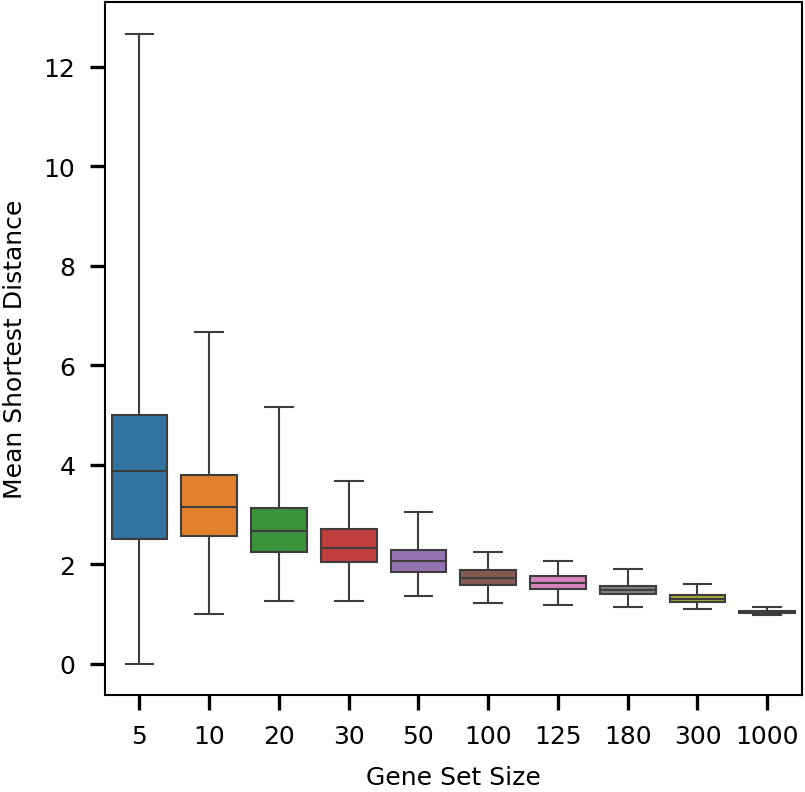

In [29]:
plt.figure(figsize=(3,3), dpi=300)
sns.boxplot(data=tmp_df, x='Set_size', y='Mean_Minimum_Distance', linewidth=0.5, fliersize = 2, whis=(0,100))
plt.ylabel('Mean Shortest Distance')
plt.xlabel('Gene Set Size')
plt.savefig('Figures/Manuscript Figures/Supplemental Figure Network Separation Parameter Space/Random Networks Mean Shortest Distance.svg', transparent=True)

In [10]:

rand_270 = []
for sz in group_szs:
    tmp_rand = random.sample(random_nets[sz],30)
    rand_270 += tmp_rand

# Now doing the dynamic network separation for each network and placing into a single large dataframe
dyn_rand_ns = []
reference_data['penalty'] = 'dynamic'
reference_data['mean_dist_penalty'] = 0 # To ensure no penalty is present
for net1 in tqdm(rand_270):
    net1_sz = len(net1.protsOI)
    for net2 in rand_270:
        if net2 == net1: # Don't check against itself
            continue
        net2_sz = len(net2.protsOI)
        s = ngramNets.network_separation(net2.G, net1.G, reference_data, force_run=True)
        dyn_rand_ns.append((net2_sz,net1_sz,s))
    


100%|██████████| 300/300 [1:54:51<00:00, 22.97s/it]


In [11]:
dyn_rand_ns_df = pd.DataFrame.from_records(dyn_rand_ns, columns=['Network_Size_1','Network_Size_2', 'Network_Separation'])

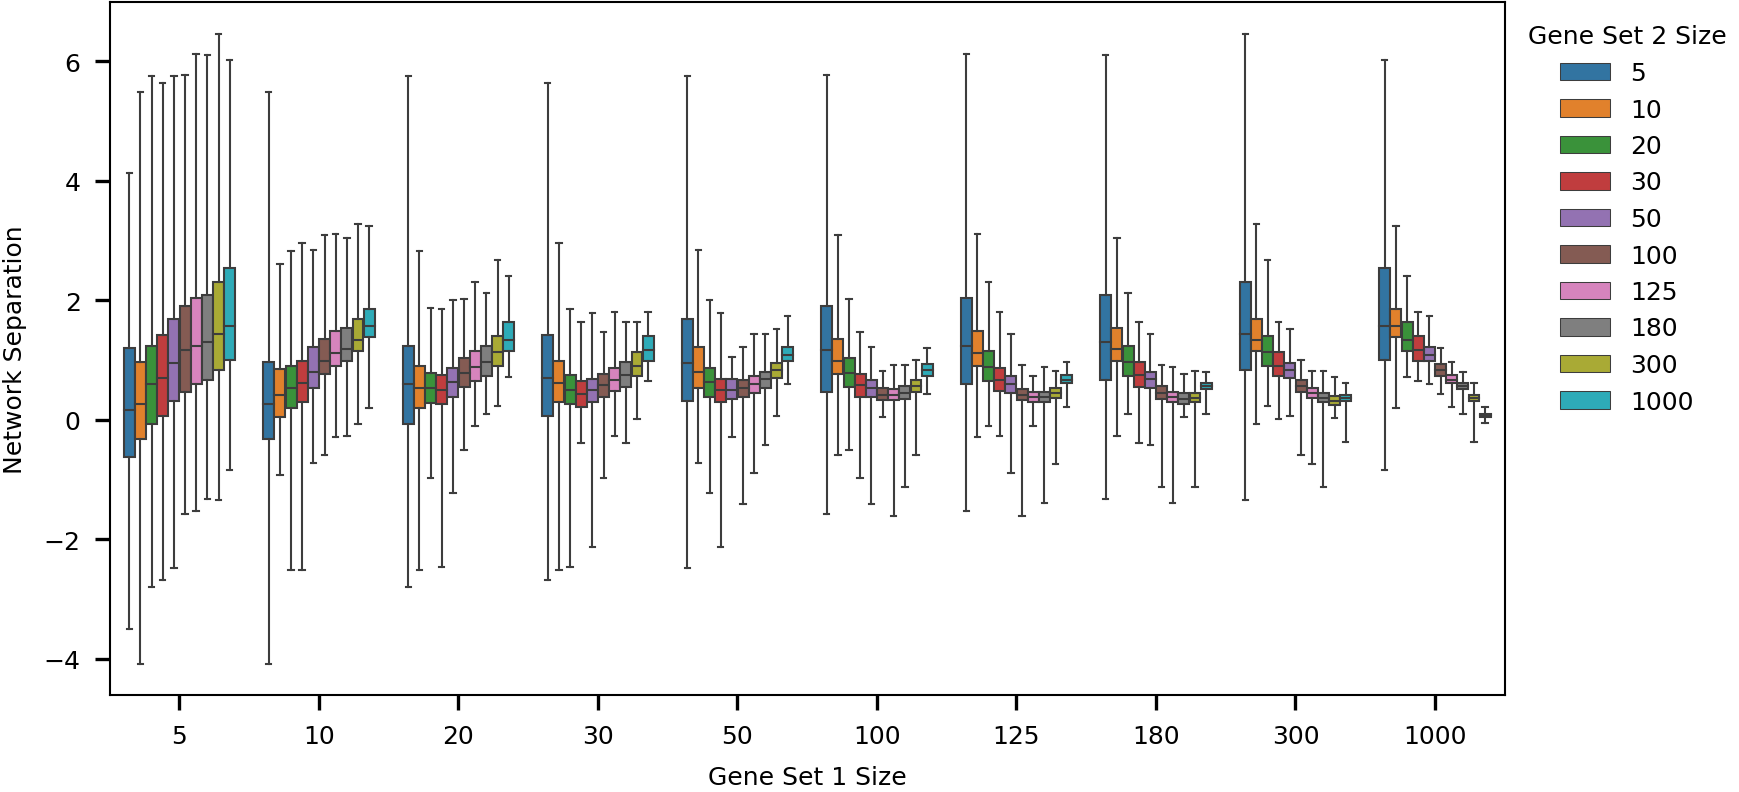

In [30]:
plt.figure(dpi=300, figsize=(6,3))
sns.boxplot(dyn_rand_ns_df, x='Network_Size_1', y = 'Network_Separation', hue='Network_Size_2',linewidth=0.5, fliersize=1, whis=(0,100))
plt.legend(bbox_to_anchor=(1.175,1), title='Gene Set 2 Size', frameon=False)
plt.ylabel('Network Separation')
plt.xlabel('Gene Set 1 Size')
plt.savefig('Figures/Manuscript Figures/Supplemental Figure Network Separation Parameter Space/Random Networks Set Size Network Separation Sweep.svg', transparent=True)

In [13]:
# To show a slightly different way to visualize the broad characterization of these results finding the inner quartile range and plotting in relationship to the gene set size.
iqr_df = pd.DataFrame(columns=group_szs, index=group_szs)
for sz in group_szs:
    for sz2 in group_szs:
        x = dyn_rand_ns_df[(dyn_rand_ns_df['Network_Size_1'] == sz) & (dyn_rand_ns_df['Network_Size_2'] == sz2)]['Network_Separation']
        iqr = stats.iqr(x)
        iqr_df.loc[sz,sz2] = iqr



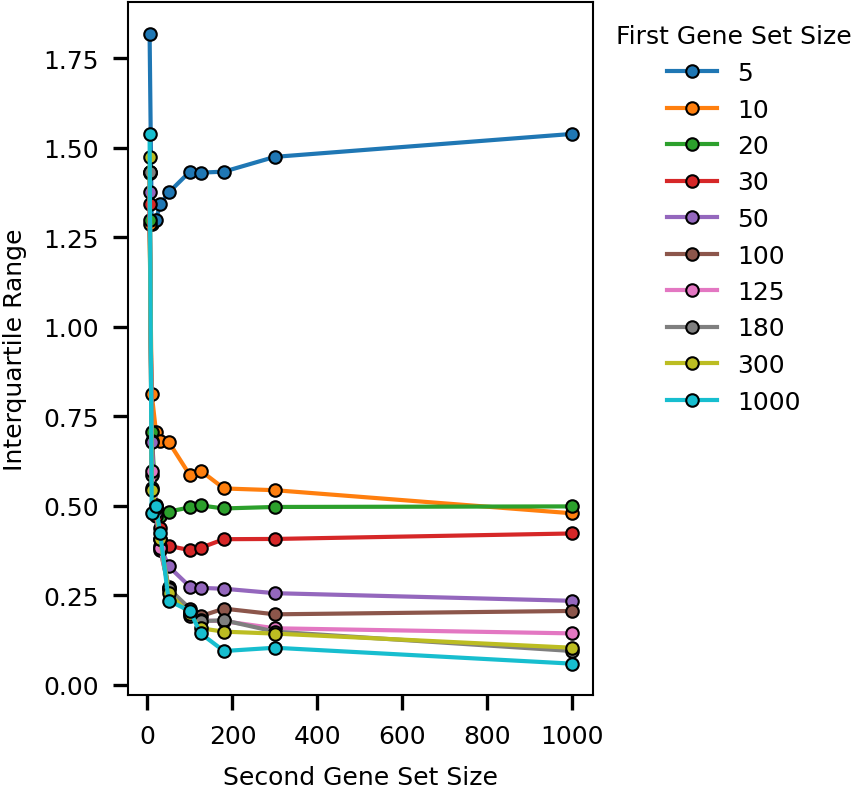

In [32]:
iqr_df.plot(kind='line', marker='o', mec='k',markersize=3, linewidth = 1, markeredgewidth=0.5)
plt.gcf().set_size_inches(2,3)
plt.gcf().set_dpi(300)
plt.legend(title='First Gene Set Size', bbox_to_anchor=(1,1),frameon=False)
plt.ylabel('Interquartile Range')
plt.xlabel('Second Gene Set Size')
plt.savefig('Figures/Manuscript Figures/Supplemental Figure Network Separation Parameter Space/Random Networks IQR Gene set size.svg', transparent=True)

In [15]:
# Given the results from above, networks that include >50 genes will be omitted for further studies. Further similarities in how 20 and 30-sized sets behave will lead to only 30 sized networks being looked at. To show the effect the penalty term has will sweep through several values using the 50 random networks on network separation values for 5, 10, 30, and 50 sized networks. Further, the dynamic penalty will be compared too.
penalty_values = list(range(0,6)) + [10,15,20,30] # Most connected components will range in diameters from 0-3 and only a small handful go up to 10.
penalty_values = ['dynamic']+penalty_values
num_penalties = len(penalty_values)
penalty_sweep_res = {}

# Here only getting the first 50 networks since that will give us a good distribution of networks that can be checked for the effect of the penalty size
random_nets_sweep = {}
for sz in [5,10,30,50]:
    temp = random.sample(random_nets[sz],50)
    random_nets_sweep[sz] = temp

for sz in [5,10,30,50]:
    sz_ns = {}
    for penalty in tqdm(penalty_values, desc=f'Starting penalty term sweep for network size: {sz}'):
        pen_ns = []
        reference_data['penalty'] = penalty # Setting up penalty
        for net1 in random_nets[sz]:
            for net2 in random_nets[sz]:
                if net2 == net1:
                    continue
                s = ngramNets.network_separation(net2, net1, reference_data, force_run=True)
                pen_ns.append(s)
        sz_ns[penalty] = pen_ns
    penalty_sweep_res[sz] = sz_ns


Starting penalty term sweep for network size: 5:   0%|          | 0/11 [00:00<?, ?it/s]/Users/yzv6ek/Documents/GitHub/Naegle Lab/ngrams/ngramNets.py:604: UserWarning: At least one network does not reach recommended minimum size, but will still be analyzed.
  warnings.warn('At least one network does not reach recommended minimum size, but will still be analyzed.')
Starting penalty term sweep for network size: 50: 100%|██████████| 11/11 [2:26:47<00:00, 800.66s/it] 


In [16]:
sweep_df = pd.DataFrame.from_dict(penalty_sweep_res)
sweep_df = sweep_df.melt(ignore_index=False, var_name='Set_size')
sweep_df.reset_index(inplace=True, names=['Penalty'])
sweep_df = sweep_df.explode('value')
sweep_df['value'] = sweep_df['value'].astype(float)

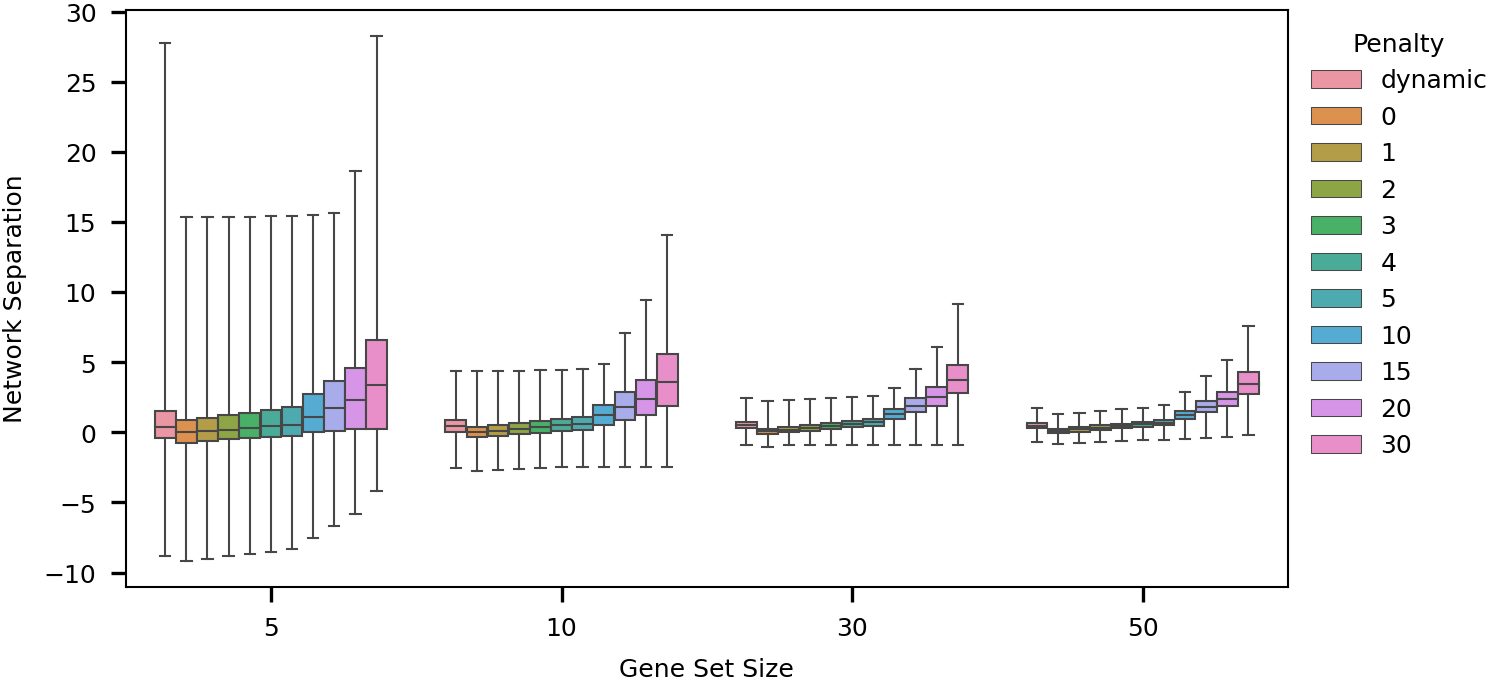

In [33]:
plt.figure(figsize=(5,2.5), dpi=300)
sns.boxplot(sweep_df, x='Set_size', y='value', hue='Penalty', linewidth=0.5, whis=(0,100))
plt.legend(bbox_to_anchor=(1,1), title='Penalty', frameon=False)
plt.ylabel('Network Separation')
plt.xlabel('Gene Set Size')
plt.savefig('Figures/Manuscript Figures/Supplemental Figure Network Separation Parameter Space/Random Networks Net Sep Penalty Sweep.svg', transparent=True)